<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/entropy.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(entropy_notebook)=
# Entropia

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

## Generalizzabilità dei modelli e fondamenti del metodo scientifico

Quando parliamo di modelli scientifici, uno degli aspetti più cruciali da considerare è la loro generalizzabilità. Questa caratteristica non è solo un punto di forza di un modello ben fatto, ma rappresenta una delle fondamenta su cui si costruisce il metodo scientifico. Senza la capacità di applicare i risultati di uno studio o modello a contesti più ampi, il valore del nostro lavoro scientifico rischia di essere fortemente limitato.

### La replicabilità come punto di partenza: un gradino ma non l'ultimo

Nel contesto del metodo scientifico, la replicabilità è spesso considerata una sorta di "biglietto d'ingresso" alla discussione scientifica. Se i risultati non sono replicabili, difficilmente possono essere considerati validi. Tuttavia, è importante sottolineare che la replicabilità è una condizione necessaria, ma non sufficiente. Un modello può essere replicabile e tuttavia non generalizzabile, il che significa che i suoi risultati non sarebbero utili al di fuori del contesto molto specifico in cui è stato testato.

### Navigare nella complessità dei modelli: tre domande per mantenere la rotta

{cite:t}`Johnson2022bayesrules` suggerisce tre domande essenziali per valutare la robustezza di un modello: quali sono le implicazioni delle nostre inferenze? Le assunzioni del modello sono valide? Quanto è accurato il modello nel fare previsioni? Quest'ultima domanda è di particolare rilevanza quando parliamo di generalizzabilità. In altre parole, un modello che può fare previsioni precise su nuovi dati ha superato una prova fondamentale della sua utilità scientifica.

### Sfide e soluzioni: bilanciare sovra-adattamento e sotto-adattamento

Una delle principali difficoltà nella creazione di modelli generalizzabili è evitare le trappole del sovra-adattamento e del sotto-adattamento {cite:p}`McElreath_rethinking`. Il primo riguarda modelli talmente specifici da essere inutili al di fuori del set di dati su cui sono stati addestrati. Il secondo rappresenta il problema opposto: modelli troppo generali per essere utili anche nel contesto per cui sono stati creati. Qui, l'approccio bayesiano offre una soluzione elegante, concentrandosi sulla capacità predittiva del modello su nuovi set di dati.

### La selezione dei modelli: un atto di equilibrio tra semplicità e precisione

Oltre ai metodi bayesiani, esistono altri principi guida nella selezione dei modelli, come il rasoio di Ockham, che ci consiglia di optare per la semplicità quando possibile. Tuttavia, questa semplicità non deve compromettere la capacità del modello di descrivere accuratamente i dati. Anche i test di ipotesi, sebbene criticati per la loro enfasi sui valori-p, rimangono uno strumento comune ma che deve essere utilizzato con attenzione per evitare errori di sovra-adattamento e sotto-adattamento.

### Verso una misurazione obiettiva: l'entropia e la divergenza di Kullback-Leibler

Quando confrontiamo modelli alternativi, spesso ci imbattiamo nella necessità di misurare quanto un modello si avvicini al "vero" processo generativo dei dati. In questo contesto, la divergenza di Kullback-Leibler rappresenta una metrica popolare che serve a quantificare questa "vicinanza".

### Selezione di modelli e entropia

Quando ci troviamo davanti alla complessa sfida di selezionare il modello che rappresenta al meglio il "vero" processo generativo dei dati, in realtà stiamo cercando un modo per quantificare quanto un modello sia "vicino" alla distribuzione sottostante dei dati. È cruciale comprendere che questa "vicinanza" è da intendersi non solo in termini della famiglia di distribuzioni (per esempio, normale contro Gamma), ma anche dei parametri specifici che caratterizzano queste distribuzioni. Per affrontare tale sfida in maniera quantitativa, un indice spesso utilizzato è la divergenza di Kullback-Leibler (KL). Tuttavia, per comprendere appieno questa metrica, è necessario prima familiarizzare con il concetto di entropia.

#### Entropia: una misura dell'incertezza

La "sorpresa" di scoprire che un evento con probabilità $ p $ si è verificato è definita come $ -\log_2(p) $, e viene misurata in un'unità chiamata bit. Eventi a bassa probabilità sono associati a un alto livello di sorpresa, mentre un evento con probabilità 1 non suscita alcuna sorpresa. Il logaritmo è incluso nella formula in modo che, se osserviamo due eventi indipendenti $ A $ e $ B $, la sorpresa totale sia la stessa della sorpresa derivante dall'osservazione dell'intersezione $ A \cap B $. La base del logaritmo è 2 per far sì che, se veniamo a sapere che un evento con probabilità $ \frac{1}{2} $ si è verificato, la sorpresa sia 1, corrispondente alla ricezione di 1 bit di informazione.

Consideriamo $ X $ come una variabile casuale discreta i cui valori distinti possibili sono $ a_1, a_2, \ldots, a_n $, con probabilità associate $ p_1, p_2, \ldots, p_n $ (tali che $ p_1 + p_2 + \cdots + p_n = 1 $). L'entropia di $ X $ è definita come la sorpresa media che si prova apprendendo il valore di $ X $:

$$
H(X) = -\sum_{x} p(x) \log_2 p(x).
$$

Da notare che l'entropia di $X$ dipende solamente dalle probabilità $p_j$, e non dai valori $a_j$. Questa formulazione dell'entropia funge da misura della quantità di informazione attesa o della sorpresa media associata all'osservazione della variabile casuale $ X $.

Per variabili continue, l'entropia si estende a:

$$
H(X) = -\int p(x) \log_2 p(x) \, dx.
$$

L'entropia raggiunge il suo valore massimo quando tutti gli esiti sono equiprobabili, il che indica il massimo grado di incertezza o variabilità nei dati. Al contrario, assume il valore minimo (cioè, zero) quando un esito è certo, segnalando l'assenza di incertezza.

#### Divergenza di Kullback-Leibler: come confrontare distribuzioni

Avendo definito l'entropia, possiamo passare alla divergenza di Kullback-Leibler (KL), che essenzialmente misura quanto due distribuzioni di probabilità differiscano tra loro. Più formalmente, la divergenza KL tra due distribuzioni $P$ e $Q$ relative alla stessa variabile aleatoria $X$ è data da:

$$
D_{KL}(P \parallel Q) = \sum_x p(x) \log \left(\frac{p(x)}{q(x)}\right) \quad \text{(per distribuzioni discrete)},
$$

oppure:

$$
D_{KL}(P \parallel Q) = \int p(x) \log \left(\frac{p(x)}{q(x)}\right) \, dx \quad \text{(per distribuzioni continue)}.
$$

Va notato che la divergenza KL è sempre non negativa e indica la quantità di informazione "persa" quando si utilizza la distribuzione $Q$ per approssimare $P$. 

In termini di entropia, la divergenza di Kullback-Leibler può essere espressa attraverso la relazione:

$$
D_{KL}(P \parallel Q) = H(P, Q) - H(P),
$$

dove $H(P, Q)$ è l'entropia incrociata tra $P$ e $Q$, e $H(P)$ è l'entropia della distribuzione $P$. Le definizioni di entropia $H(P)$ e entropia incrociata $H(P, Q)$ sono rispettivamente:

$$
\begin{align}
H(P) &= -\sum_x p(x) \log(p(x)),\notag\\
H(P, Q) &= -\sum_x p(x) \log(q(x)).
\end{align}
$$

L'entropia $H(P)$ misura l'incertezza intrinseca nella distribuzione $P$, mentre l'entropia incrociata $H(P, Q)$ misura l'incertezza quando si utilizza $Q$ per approssimare $P$.

In questi termini, dunque, la divergenza di Kullback-Leibler indica la differenza tra la sorpresa media che sperimentiamo quando le probabilità effettive sono $ p $, ma stiamo operando con $ q $ (ad esempio, se $ p $ è sconosciuta e $ q $ è la nostra stima attuale per $ p $), e la nostra sorpresa media quando operiamo con $ p $.

Nella pratica, la divergenza di Kullback-Leibler è spesso utilizzata come criterio di selezione di modelli. In tale contesto, l'obiettivo è di trovare un modello $Q$ che minimizzi $D_{KL}(P \parallel Q)$, o equivalentemente, che minimizzi la differenza $H(P, Q) - H(P)$.

Un punto da notare è che $D_{KL}(P \parallel Q)$ è non negativa e assume il valore di zero se e solo se $P$ e $Q$ sono la stessa distribuzione. Inoltre, non è simmetrica, cioè $D_{KL}(P \parallel Q) \neq D_{KL}(Q \parallel P)$.

In sintesi, la divergenza di Kullback-Leibler fornisce un modo per collegare l'entropia di due distribuzioni differenti, fornendo un criterio quantitativo per valutare quanto una distribuzione $Q$ sia una buona approssimazione di un'altra distribuzione $P$, tenendo in conto le incertezze intrinseche in entrambe.

#### Applicazione nella selezione di modelli

Nel contesto della selezione di modelli, l'obiettivo è individuare il modello $Q$ che minimizzi la divergenza KL rispetto alla "vera" distribuzione $P$ dei dati. Tuttavia, nella maggior parte dei casi, la distribuzione "vera" $P$ è sconosciuta e non direttamente osservabile. Di conseguenza, si utilizzano dei criteri approssimativi come il Criterio di Informazione di Akaike (AIC) o il Criterio di Informazione Bayesiano (BIC), che agiscono come stime surrogate per la minimizzazione della divergenza KL.

## Esempi concreti

Esaminiamo alcuni esempi per chiarire il concetto di entropia.

### L'entropia di un singolo evento

Consideriamo il lancio di una moneta equilibrata. La probabilità di testa (e croce) è 0.5. La quantità di informazione di ottenere "testa" è dunque

In [10]:
-np.log2(0.5)

1.0

La scelta di utilizzare un logaritmo in base 2 per la formula dell'entropia implica che l'unità di misura dell'informazione sarà il bit, o cifra binaria. Questo significa che l'entropia, in questa formulazione, indica il numero di bit necessari per rappresentare un determinato evento.

L'entropia $ H(p) $ serve a quantificare la quantità di informazione ottenuta osservando una variabile casuale di Bernoulli $ \text{Bern}(p) $. Ad esempio, se $ H(p = 0.5) = 1 $, ciò suggerisce che un lancio di una moneta perfettamente equilibrata genera 1 bit di informazione. In contrasto, $ H(p = 1) = 0 $ implica che, in un contesto in cui la moneta genera sempre "Testa", osservare l'esito del lancio non fornisce alcuna informazione aggiuntiva, dato che l'evento è prevedibile con certezza.

Se si effettuano $ n $ lanci della stessa moneta, ognuno di questi lanci contribuirà con 1 bit all'informazione totale. Quindi, la sequenza completa di $ n $ lanci richiederà un totale di $ n $ bit di informazione per essere rappresentata integralmente.

Nel caso in cui la moneta sia sbilanciata, con una probabilità di "Testa" pari a 0.1, per esempio, l'evento "Testa" diventa più raro e, quindi, necessita di più di 3 bit di informazione per essere adeguatamente rappresentato:

In [11]:
-np.log2(0.1)

3.321928094887362

Consideriamo il caso di un dado a sei facce e focalizziamoci sull'evento "uscita del numero 6". La probabilità di tale evento è 1/6, che è inferiore alla probabilità di 1/2 di ottenere "testa" con un lancio di moneta. Di conseguenza, ci aspettiamo che l'evento "uscita del numero 6" generi una sorpresa maggiore rispetto all'evento "testa". In termini numerici, l'informazione associata all'evento "uscita del numero 6" sarà quindi superiore a quella legata all'evento "testa".

Per quantificare questa informazione, possiamo usare la formula dell'informazione di Shannon:

$$
-\log_2\left(\frac{1}{6}\right) \approx 2.58 \text{ bit}.
$$

Questo valore è effettivamente superiore a 1 bit, che è l'informazione necessaria per rappresentare l'evento "testa" in un lancio di moneta. Più specificamente, l'informazione associata all'evento "uscita del numero 6" è più del doppio rispetto a quella dell'evento "testa". In questo modo, quantifichiamo matematicamente la nostra intuizione che l'evento legato al dado è più "sorprendente" rispetto a quello legato alla moneta.

### Informazione di Shannon e entropia

L'informazione di Shannon e l'entropia sono concetti strettamente correlati. La differenza principale sta nel fatto che l'informazione di Shannon si riferisce a un singolo evento, mentre l'entropia è una misura aggregata che prende in considerazione l'intera distribuzione di probabilità di una variabile aleatoria. 

L'informazione di Shannon $ I(x) $ è una misura della quantità di informazione contenuta in un singolo evento $ x $ e dipende dalla sua probabilità $ p(x) $. È definita come:

$$
I(x) = -\log_{2}(p(x)).
$$

L'informazione è elevata quando la probabilità dell'evento è bassa (cioè, l'evento è raro e quindi più "sorprendente") e viceversa.

L'entropia $ H(X) $, d'altro canto, è una misura dell'incertezza media associata a una variabile aleatoria $ X $ con distribuzione di probabilità $ p(x) $. È definita come l'aspettazione matematica dell'informazione di Shannon per tutti gli esiti possibili $ x $ di $ X $:

$$
H(X) = \mathbb{E}[I(X)] = -\sum_{x \in X} p(x) \log_{2}(p(x)).
$$

Quindi, l'entropia è la media pesata delle informazioni di Shannon associate a ciascun possibile esito di $ X $. In altre parole, l'entropia è la media logaritmica della probabilità di un evento.

Quindi, mentre l'informazione di Shannon ci dice quanto saremmo "sorpresi" di osservare un singolo esito, l'entropia ci dà una misura aggregata della nostra "sorpresa" attesa nel lungo periodo, considerando tutti gli esiti possibili.

Nella figura successiva viene esaminata la relazione tra probabilità e informazione, per valori di probabilità nell'intervallo tra 0 e 1.

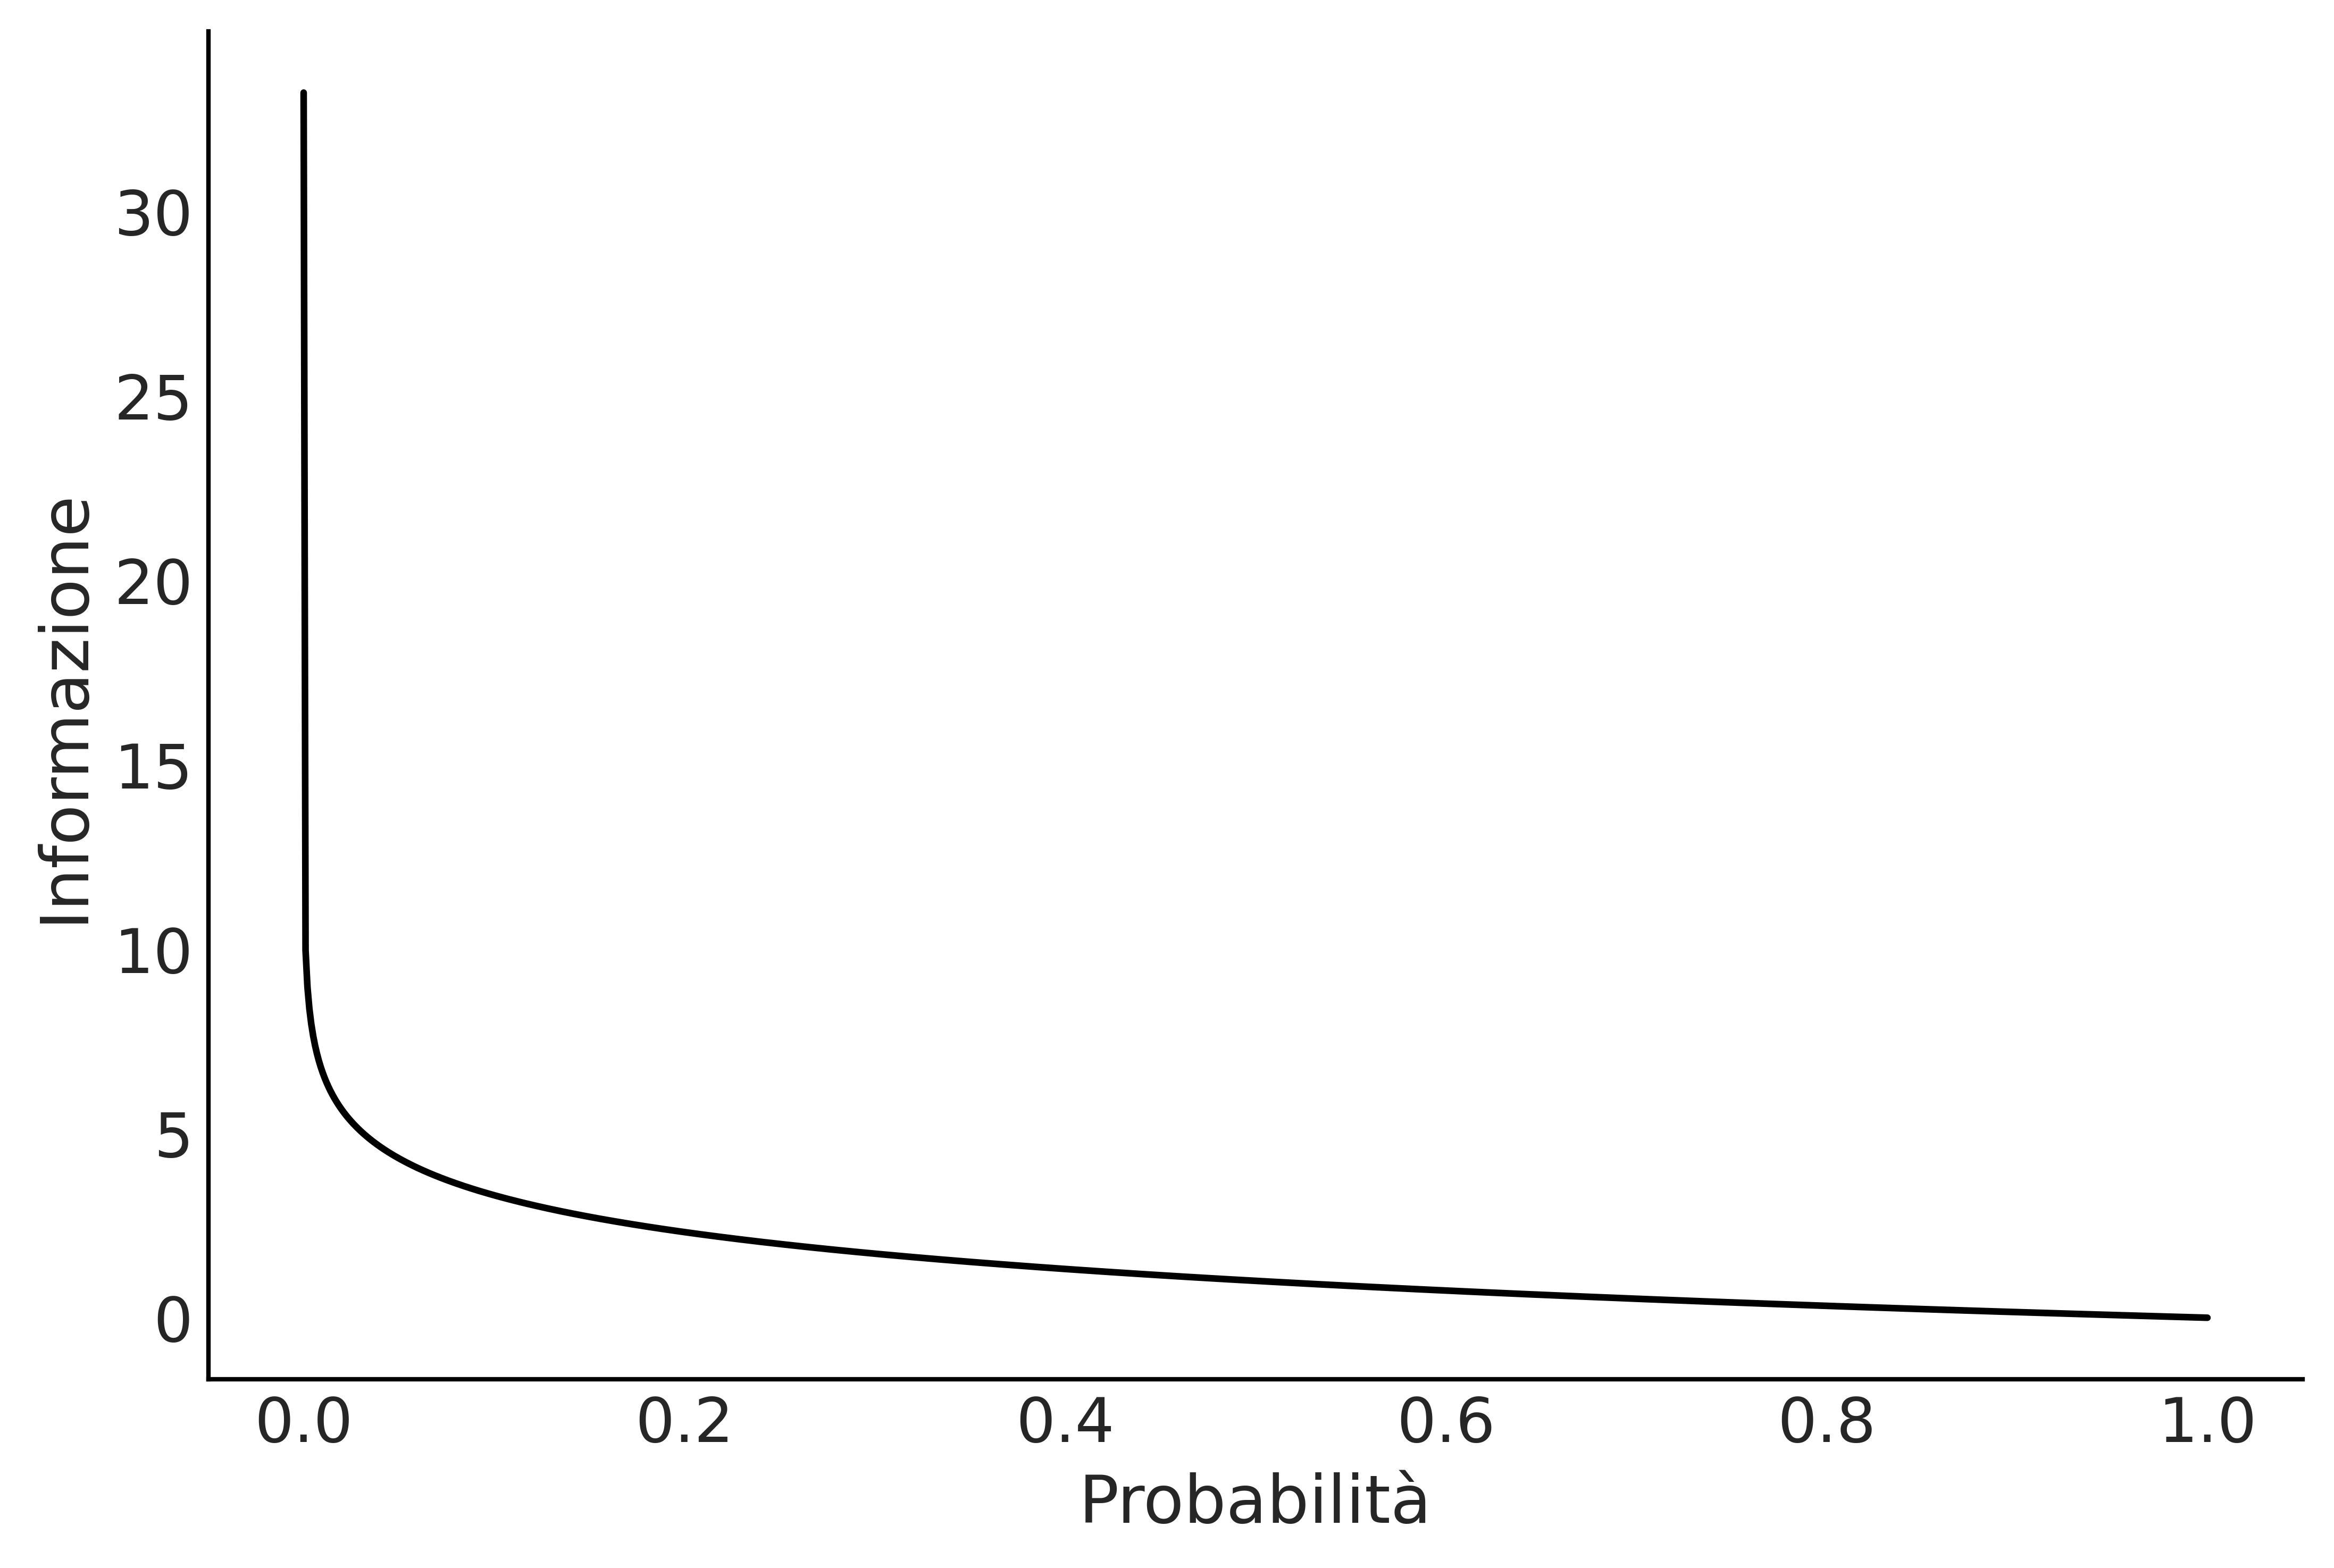

In [3]:
# Create a sequence of 1000 equally spaced points from 0 to 1
p = np.linspace(0, 1, 1000)

# Avoid log(0) by replacing 0 with a small value
p[p == 0] = 1e-10

# Compute the negative log base 2 of p
h = -np.log2(p)

df = pd.DataFrame({'Probabilità': p, 'Informazione': h})

plt.plot('Probabilità', 'Informazione', data=df)
plt.xlabel('Probabilità')
plt.ylabel('Informazione');

La figura mostra che questa relazione non è lineare, è infatti leggermente sublineare. Questo ha senso dato che abbiamo usato una funzione logaritmica.

#### Entropia e varianza di una distribuzione

Si potrebbe pensare che l'entropia aumenti in maniera parallela alla varianza. Infatti, in alcuni casi questo avviene.

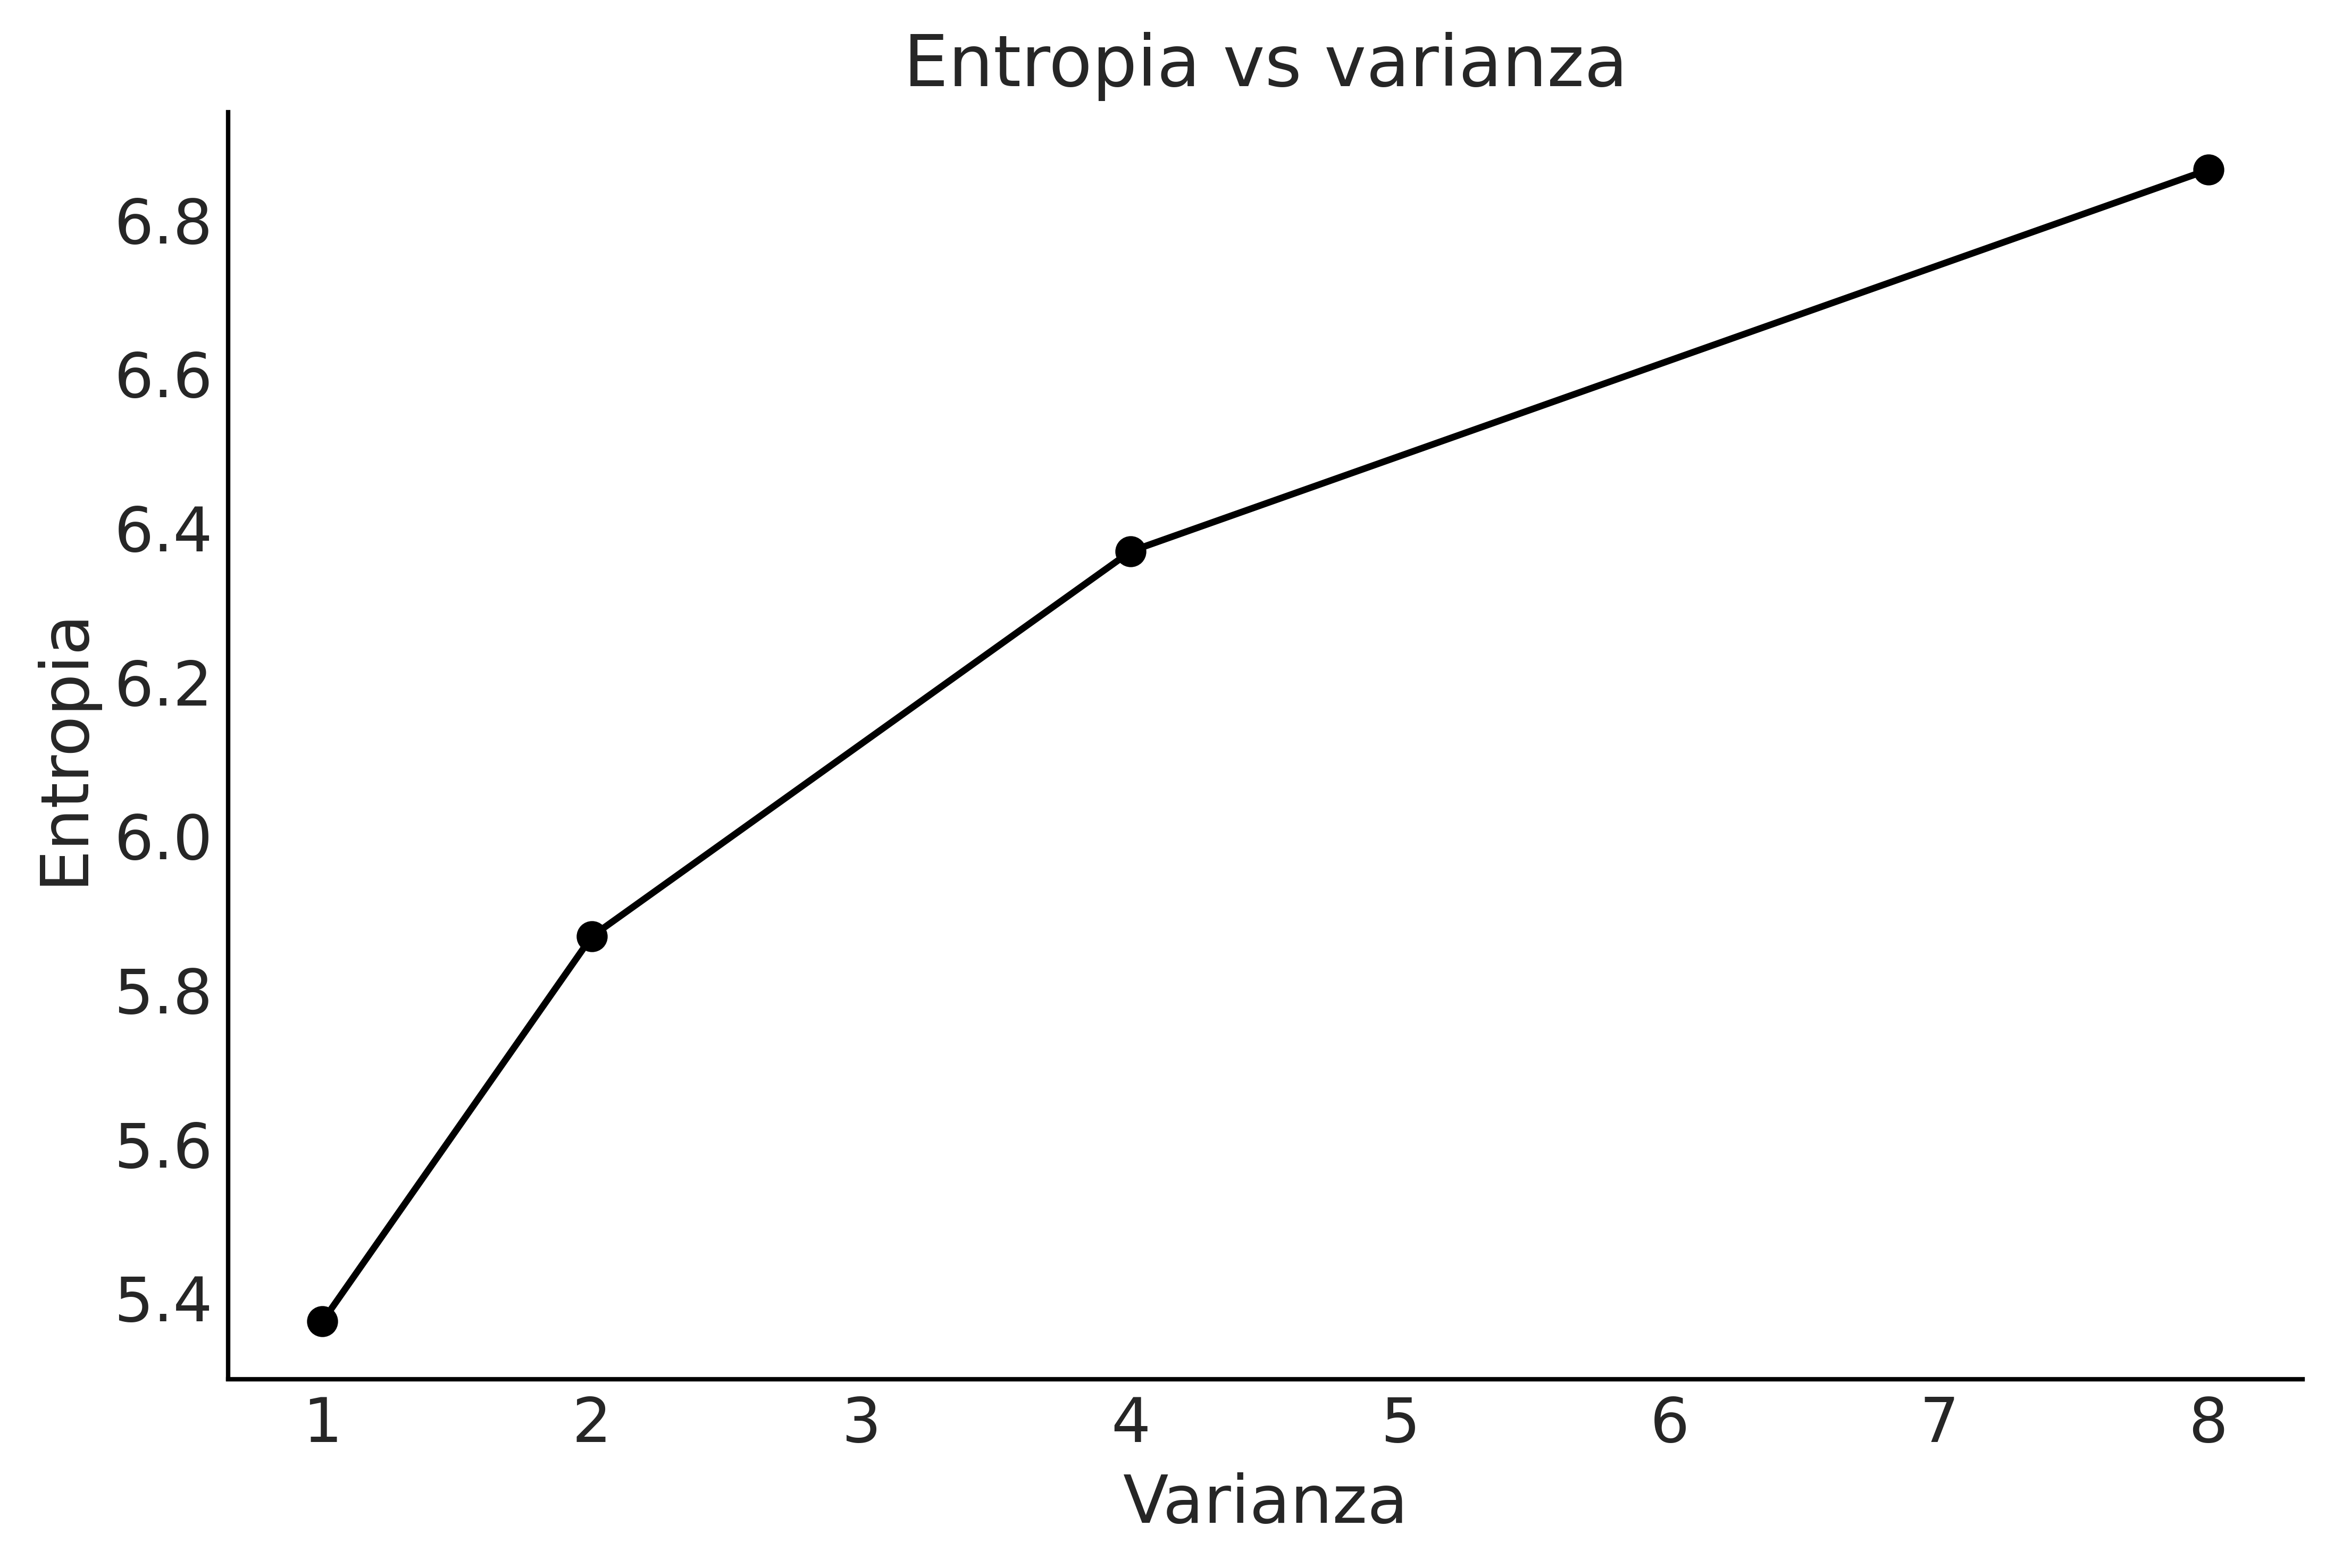

In [4]:
# Intervallo di valori discreti
x = np.arange(-10, 10, 0.1)

def calculate_entropy(variance):
    # Distribuzione normale con media 0 e varianza specifica
    probabilities = stats.norm.pdf(x, 0, np.sqrt(variance))
    
    # Normalizzazione delle probabilità in modo che sommino a 1
    probabilities /= probabilities.sum()
    
    # Calcolo dell'entropia
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Varianze da esplorare
variances = [1, 2, 4, 8]

# Calcolo e tracciamento dell'entropia per diverse varianze
entropies = [calculate_entropy(variance) for variance in variances]

plt.plot(variances, entropies, marker='o')
plt.title('Entropia vs varianza')
plt.xlabel('Varianza')
plt.ylabel('Entropia');

Ma la relazione tra entropia e varianza non è così semplice. In questo secondo esempio, infatti, abbiamo un entropia maggiore per la distribuzione con varianza minore.

In [5]:
def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log2(probabilities))

# Distribuzioni con la stessa varianza ma diverse probabilità
probabilities1 = np.array([0.5, 0.25, 0.25])
probabilities2 = np.array([0.3333, 0.3333, 0.3334])

# Calcolo dell'entropia per entrambe le distribuzioni
entropy1 = calculate_entropy(probabilities1)
entropy2 = calculate_entropy(probabilities2)

print(f"Entropia della distribuzione 1: {entropy1}")
print(f"Entropia della distribuzione 2: {entropy2}")

Entropia della distribuzione 1: 1.5
Entropia della distribuzione 2: 1.5849624862946867


In sintesi, sia l'entropia che la varianza sono indicatori che ci parlano dell'incertezza in una distribuzione di dati, ma lo fanno attraverso ottiche differenti e non sono strettamente interconnesse.

- **Varianza**: Questa metrica si focalizza sulla dispersione dei dati rispetto al loro valore medio. Essa quantifica quanto i singoli dati si discostano dalla media aritmetica, senza però tener conto delle probabilità associate a ciascun valore. In altre parole, la varianza è indifferente alla distribuzione delle probabilità dei vari esiti.

- **Entropia**: Al contrario, l'entropia è una misura che valuta direttamente l'incertezza della distribuzione di probabilità. Essa considera la probabilità di ogni possibile esito e quantifica l'incertezza media che si avrebbe nell'osservare un esito casuale. L'entropia, quindi, è sensibile alla struttura delle probabilità, a prescindere dal valore assoluto delle variabili casuali in questione.

Di conseguenza, è del tutto possibile incontrare distribuzioni che, pur avendo la stessa varianza, presentano entropie differenti, e viceversa. Questo perché la relazione tra varianza ed entropia non è univoca e dipende da come sono configurate le probabilità all'interno della distribuzione.

### Esercizio sulla divergenza di Kullback-Leibler

Immaginatevi in una situazione di esame a scelta multipla, ma con un'importante variante: anziché selezionare una singola risposta per domanda, dovete assegnare una probabilità di correttezza a ciascuna opzione. Il punteggio che otterrete per ogni domanda sarà calcolato utilizzando il logaritmo della probabilità che avete attribuito all'opzione effettivamente corretta. In formule, se la risposta giusta è $A_i$, il vostro punteggio per quella specifica domanda sarà $\log(p_i)$, dove $p_i$ è la probabilità assegnata a $A_i$.

La scala di punteggio è tale che il massimo che potete ottenere per una singola domanda è 0 (se assegnate una probabilità del 100% alla risposta corretta), mentre il minimo è $-\infty$ se assegnate una probabilità di zero alla risposta giusta. Il vostro obiettivo finale è massimizzare il punteggio atteso per l'intero esame. Quali probabilità vi conviene riportare?

Poiché non sapete a priori quale sia la risposta corretta per ogni domanda, le vostre "migliori stime personali" delle probabilità diventano cruciali. Supponiamo che queste stime personali siano rappresentate dal vettore $p = [p_1, p_2, \ldots, p_n]$.

Il punteggio atteso, calcolato sulla base di queste stime, è dato da:

$$
\text{Punteggio atteso con } p = \sum_{i=1}^{n} p_i \log(p_i).
$$

Ora, immaginate di essere tentati di manipolare tali stime, utilizzando un set di probabilità alternativo $q = [q_1, q_2, \ldots, q_n]$. In tal caso, il punteggio atteso diventerebbe:

$$
\text{Punteggio atteso con } q = \sum_{i=1}^{n} p_i \log(q_i).
$$

La differenza tra i due punteggi attesi è esattamente la divergenza Kullback-Leibler (KL) tra i vettori di probabilità $p$ e $q$:

$$
\Delta = D_{KL}(p \parallel q) = \sum_{i=1}^{n} p_i \log\left(\frac{p_i}{q_i}\right)
$$

Questa divergenza KL è sempre non negativa e si annulla solo nel caso in cui $p = q$. Ciò implica che il punteggio atteso è massimizzato quando si utilizzano le migliori stime personali $p$.

In un contesto come quello descritto, dunque, massimizzare il punteggio atteso equivale a utilizzare le vostre stime più accurate, basate sulle informazioni a vostra disposizione. Qualsiasi tentativo di "manipolare" queste stime introduce una forma di "rumore" o "distorsione" non informativa, che finisce per ridurre il vostro punteggio atteso. Detto in modo più semplice: le vostre migliori stime personali rappresentano la comprensione più accurata che avete del problema in questione. Deviare da queste stime, senza una giustificazione basata su nuove informazioni, equivale a sabotare le vostre possibilità di successo.

Così, nel sistema di punteggio basato sul logaritmo delle probabilità, non solo non c'è alcun vantaggio nel cercare di "ingannare" il sistema, ma qualsiasi tentativo in tal senso si traduce in una penalizzazione nel punteggio atteso. Questo allinea perfettamente con i principi della teoria delle decisioni bayesiane, che premia la trasparenza e l'accuratezza nelle stime probabilistiche.

Qui sotto è fornita una dimostrazione numerica dei calcoli necessari. 

In [4]:
# True probabilities
p = np.array([0.7, 0.2, 0.1])

# Another set of probabilities
q = np.array([0.5, 0.3, 0.2])

# Calculate expected score for p
expected_score_p = np.sum(p * np.log(p))

# Calculate expected score for r
expected_score_q = np.sum(p * np.log(q))

# Calculate the difference in expected scores
delta = expected_score_p - expected_score_q

# Calculate KL divergence between p and r
kl_divergence = np.sum(p * np.log(p / q))

expected_score_p, expected_score_q, delta, kl_divergence

(-0.8018185525433374,
 -0.886941378500559,
 0.08512282595722154,
 0.0851228259572216)

## Commenti e considerazioni finali 

In questo capitolo, abbiamo esplorato il concetto di entropia come mezzo per quantificare l'incertezza associata a una distribuzione di probabilità. Tuttavia, potrebbe sorgere una domanda naturale: come possiamo utilizzare l'entropia per esprimere la "distanza" tra un modello teorico e il vero processo che genera i dati? La chiave per comprendere questa connessione risiede nella divergenza di Kullback-Leibler. Questo concetto, che abbiamo introdotto brevemente, serve proprio a misurare la differenza tra due distribuzioni probabilistiche e svolgerà un ruolo centrale nella nostra discussione nel prossimo capitolo, dove verrà esplorato in maggiori dettagli.

## Watermark

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 05 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

statsmodels: 0.14.0
numpy      : 1.25.2
seaborn    : 0.12.2
pandas     : 2.1.0
scipy      : 1.11.2
matplotlib : 3.7.2
arviz      : 0.16.1

Watermark: 2.4.3

